In [1]:
%load_ext autoreload
%autoreload all

In [2]:
from ptdalgorithms import Graph, SVGD, analyze_svgd_profile, set_theme, clear_cache
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colors
set_theme('dark')

%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'

# "iridis" color map (viridis without the deep purple)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

from functools import partial

import cProfile, pstats
profiler = cProfile.Profile()

In [3]:

def construct_rabbit_model(nr_rabbits=3):
    """
    Construct parameterized rabbit island model.

    State: [n_left, n_right]
    Transitions:
      - Jump: (n_l, n_r) → (n_l-1, n_r+1) at rate n_l * θ₀
      - Left flood: (n_l, n_r) → (0, n_r) at rate θ₁
      - Right flood: (n_l, n_r) → (n_l, 0) at rate θ₂

    Parameters:
      nr_rabbits: Number of rabbits starting on left island

    Returns:
      Graph with parameterized edges
    """
    graph = Graph(state_length=2)

    # Initial state: all rabbits on left
    initial_state = np.array([nr_rabbits, 0], dtype=np.int32)
    start = graph.starting_vertex()
    start.add_edge(graph.find_or_create_vertex(initial_state), 1.0)

    # Build state space
    index = 1
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()
        n_left, n_right = state[0], state[1]

        # Rabbit jumps left→right: rate = n_left * θ₀
        if n_left > 0 and n_right < nr_rabbits:
            child_state = np.array([n_left - 1, n_right + 1], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [float(n_left), 0.0, 0.0]  # Coefficients for [θ₀, θ₁, θ₂]
            )

        # Left island floods: rate = θ₁
        if n_left > 0:
            child_state = np.array([0, n_right], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [0.0, 1.0, 0.0]
            )

        # Right island floods: rate = θ₂
        if n_right > 0:
            child_state = np.array([n_left, 0], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [0.0, 0.0, 1.0]
            )

        index += 1

    return graph


def build_exponential_graph():
    """
    Build single exponential distribution with parameterized rate.

    Returns:
        Graph with exponential distribution: S → [2] → [1]
        - S (state [0]) → [2] with probability 1.0 (initial transient state)
        - [2] → [1] with rate θ (parameterized, absorbing state)

    Note: Starting vertex has implicit state [0], so initial transient state
    must use a different state value (here [2]) to avoid duplication.

    The edge rate = base_weight + coefficients @ theta
    For single exponential: rate = 0.0 + 1.0 * theta[0] = theta[0]
    """
    g = Graph(state_length=1)
    start = g.starting_vertex()

    # Initial transient state [2] (can't use [0] as it conflicts with starting vertex)
    v2 = g.find_or_create_vertex([2])
    # Absorbing state [1]
    v1 = g.find_or_create_vertex([1])

    # Starting vertex → initial state (probability 1.0)
    start.add_edge(v2, 1.0)

    # Initial state → absorbing state (parameterized rate = theta[0])
    # Parameterized edge: rate = weight + edge_state @ theta
    # For single exponential: rate = 0.0 + [1.0] @ theta = theta[0]
    v2.add_edge_parameterized(v1, 0.0, [1.0])

    return g


In [4]:
clear_cache()

Clearing cache: /Users/kmt/.jax_cache
  Files: 3
  Size: 2.8 MB
✓ Cache cleared successfully


In [16]:
np.random.seed(42)

true_theta, construct_graph = [2.0], build_exponential_graph
# true_theta, construct_graph = [2.0, 3.0, 1.0], partial(construct_rabbit_model, 2)

#############
# This is doing eliminating just for sampling - just for testing...
n_obs = 5000
_graph = construct_graph()
_graph.update_parameterized_weights(true_theta)
observed_data = np.array(_graph.sample(n_obs))
#############

graph = construct_graph()


# def parameterized_pdf(theta, data):
#     graph.update_parameterized_weights(theta)
#     return graph.pmf


# ADD A REWARD MATRIX AS INPUT TO ALLOW INPUT TO BE AN N-DIM ONE-HOT VECTOR OF TONS...
# I would like to change the format of observable data taked by STGD() from an array of values, to a 2d array. More precisely it will be an array of arrays, where the inner arrays represent observations. Each observation has only a single non-zero value. 
# 
# The indices of the second dimension of observed data will correspond to the second dimension of the specified reward matrix. If the second dimensions have length n, then the compiled pdf function should compute n marmginal pdf functions and evaluate each observation in accordance with its positions in the observation array.

# 
#  of values. 
# 
#  to accept two-dimentional data the first dimention retpresents dataponts and the second represents 
# 
# (Array of arrays) observed_data 

parameterized_pdf = Graph.pmf_from_graph(
    graph,
    # discrete=False,
)

# test_theta = jnp.array(true_theta)
# test_times = jnp.array([0.5, 1.0, 1.5])
# test_pdf = pparameterized_pdfdf(test_theta, observed_data)
# print(test_pdf)

n_particles = 20 * len(true_theta)
n_iterations = 1000
#learning_rate = 0.01
svgd = SVGD(parameterized_pdf, observed_data, theta_dim=len(true_theta),
            n_iterations=n_iterations,
            
#            learning_rate=learning_rate,
            verbose=True,
)

Initialized 20 particles with theta_dim=1 from N(0,1)
Detected model type: returns pmf only

Precompiling gradient function...
  Theta shape: (1,), Times shape: (5000,)
  This may take several minutes for large models...
  JIT compiling gradient...
  Gradient JIT compiled in 0.0s
  Precompilation complete!


INFO: loaded elimination trace from cache (f168bd5cfa449018cbcbb90b6b7f707e7d526ae38cb4acab5b3c120c04a41a97): 11 operations, 3 vertices
INFO: loaded elimination trace from cache (f168bd5cfa449018cbcbb90b6b7f707e7d526ae38cb4acab5b3c120c04a41a97)


In [17]:
svgd.fit(return_history=True)


Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 5000
  Prior: standard normal
Running SVGD: 1000 steps, 20 particles



SVGD complete!
Posterior mean: [0.84431707]
Posterior std:  [1.42562884]


In [18]:
svgd.get_results()

{'particles': Array([[ 1.96033728],
        [-1.74690841],
        [ 1.9764684 ],
        [ 1.97193382],
        [ 1.97565783],
        [ 1.99111002],
        [ 1.99075827],
        [ 1.98149531],
        [-0.48148346],
        [-0.37119801],
        [-0.46190827],
        [-1.15758739],
        [ 1.97220273],
        [ 1.96533254],
        [ 1.97990772],
        [-0.50224374],
        [-1.58261509],
        [ 1.99568806],
        [-0.53082017],
        [ 1.960214  ]], dtype=float64),
 'theta_mean': Array([0.84431707], dtype=float64),
 'theta_std': Array([1.42562884], dtype=float64),
 'history': [Array([[-0.18471175],
         [-2.16982456],
         [ 0.18693555],
         [ 0.61226536],
         [ 0.48962495],
         [ 0.3690043 ],
         [ 0.37087464],
         [ 0.23532732],
         [-0.71689883],
         [-0.63462433],
         [-0.70002188],
         [-1.57655813],
         [ 0.59787087],
         [ 0.90924046],
         [ 0.22326622],
         [-0.73598678],
         [-2.0

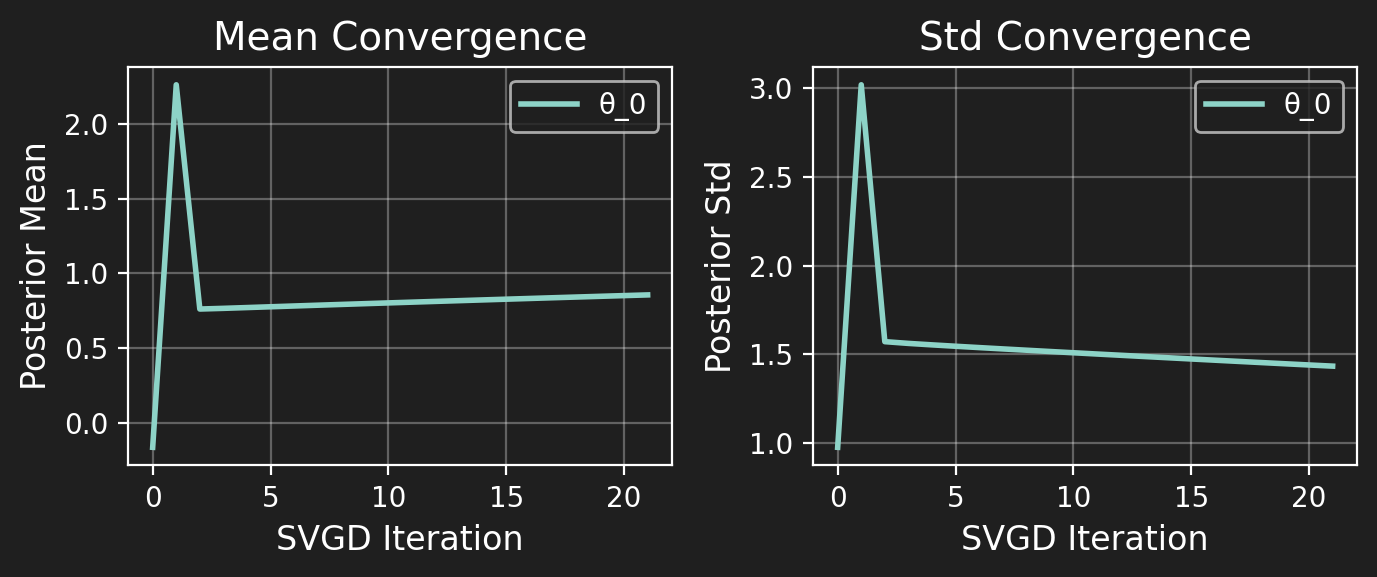

In [15]:
svgd.plot_convergence(show_transformed=True) ;

20


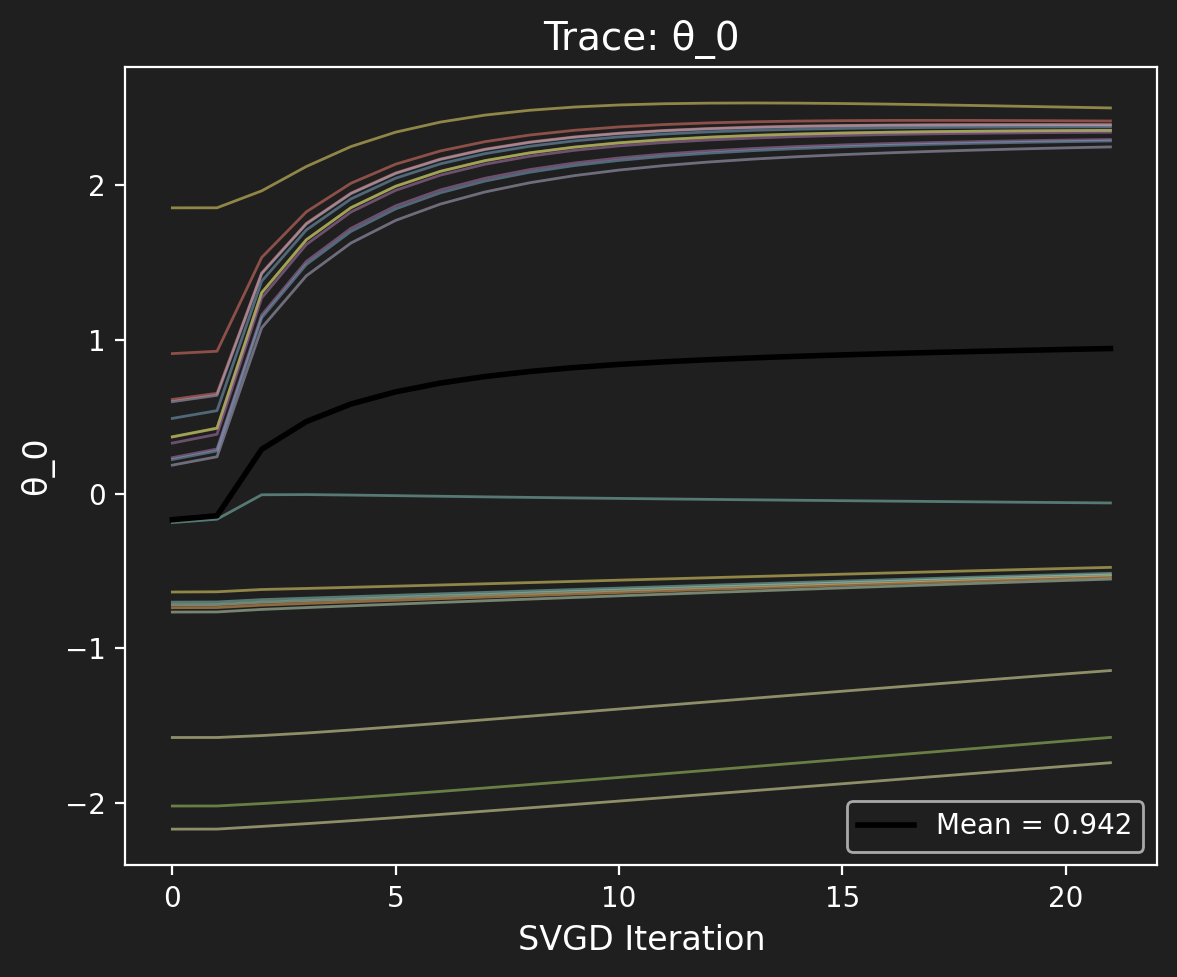

In [8]:
svgd.plot_trace(show_transformed=True) ;

In [9]:
svgd.summary()

SVGD Inference Summary
Number of particles: 20
Number of iterations: 1000
Parameter dimension: 1

Posterior estimates:
  θ_0: 0.9420 ± 1.6079
       95% CI: [-1.6620, 2.4596]


TypeError: unsupported format string passed to list.__format__

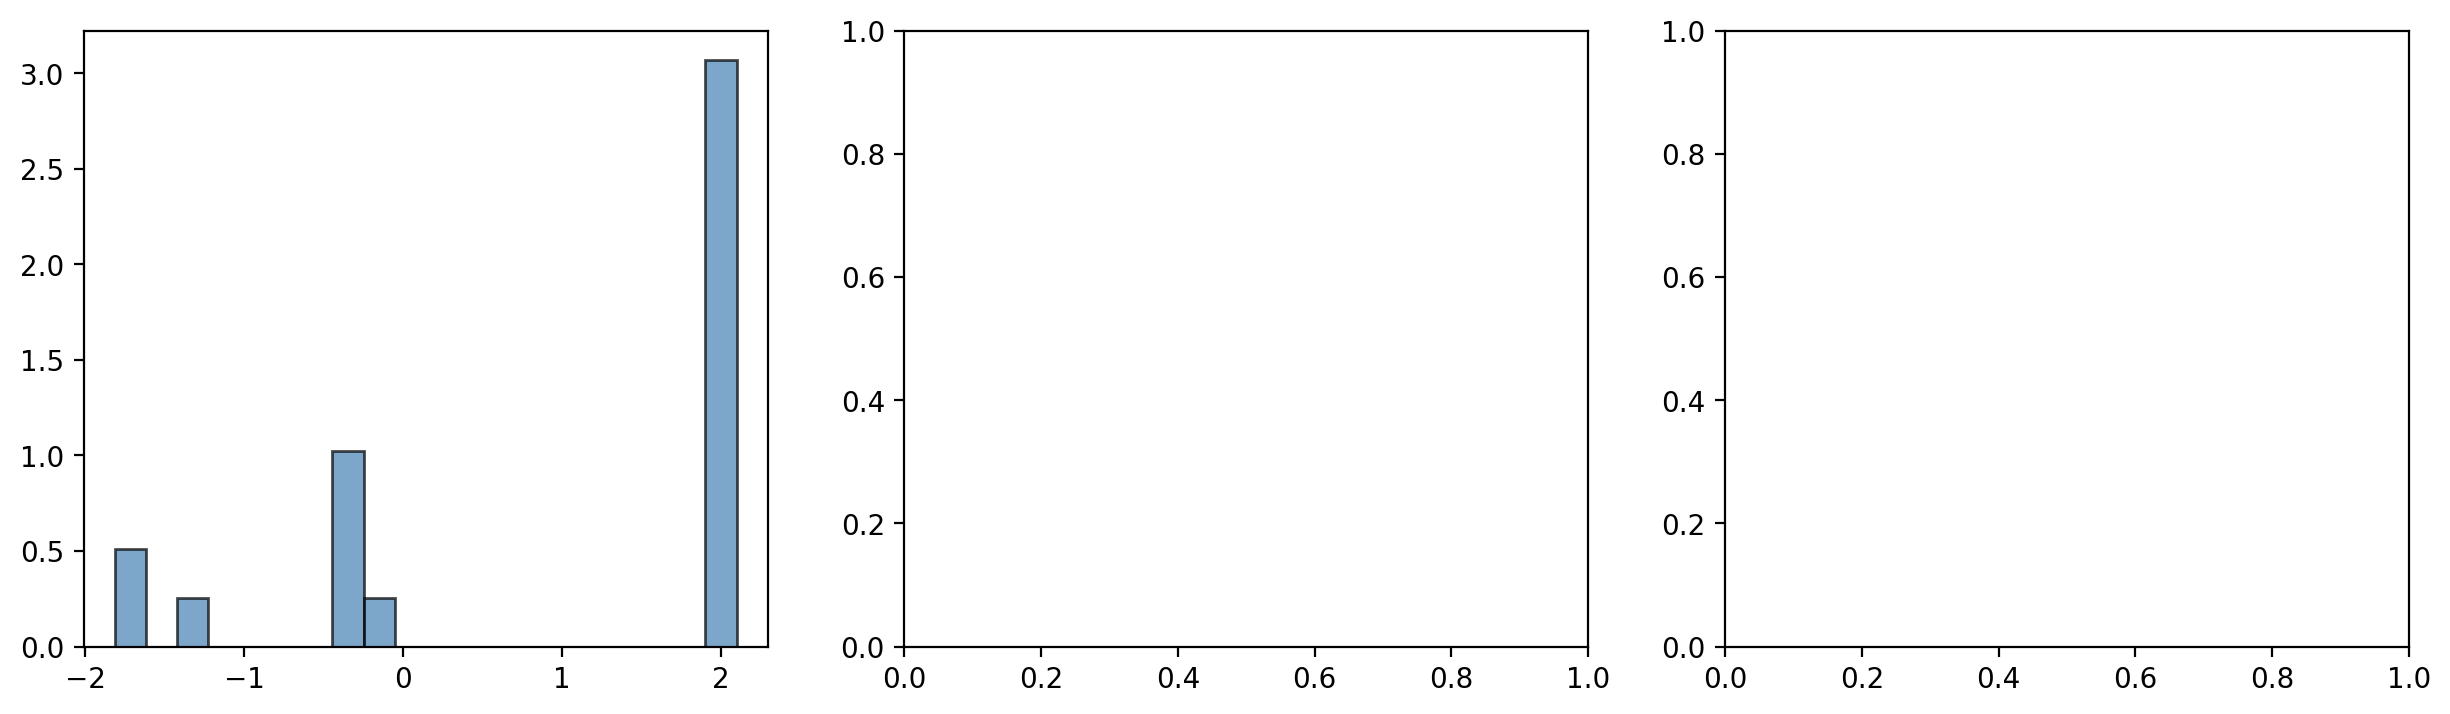

In [64]:
results = svgd.get_results()

# print("Step 4: Analyzing Results")
# print("-" * 70)

particles = results['particles']
posterior_mean = results['theta_mean'][0]
posterior_std = results['theta_std'][0]

ci_lower = np.percentile(particles[:, 0], 2.5)
ci_upper = np.percentile(particles[:, 0], 97.5)

# print(f"  True θ:         {true_theta:.3f}")
# print(f"  Posterior mean: {posterior_mean:.3f}")
# print(f"  Posterior std:  {posterior_std:.3f}")
# print(f"  95% CI:         [{ci_lower:.3f}, {ci_upper:.3f}]")

# error_pct = abs(posterior_mean - true_theta) / true_theta * 100
# print(f"  Relative error: {error_pct:.1f}%")

# contains_true = ci_lower <= true_theta <= ci_upper
# print(f"  CI contains true: {'✓ YES' if contains_true else '✗ NO'}\n")


# print("Step 5: Creating Visualization")
# print("-" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Posterior distribution
ax = axes[0]
ax.hist(particles[:, 0], bins=20, density=True, alpha=0.7,
        color='steelblue', edgecolor='black')
ax.axvline(true_theta, color='red', linestyle='--', linewidth=2,
            label=f'True: {true_theta:.2f}')
ax.axvline(posterior_mean, color='darkblue', linestyle='-', linewidth=2,
            label=f'Mean: {posterior_mean:.2f}')
ax.axvline(ci_lower, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(ci_upper, color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
            label='95% CI')
ax.set_xlabel('θ (rate parameter)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Posterior Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Observed data
ax = axes[1]
ax.hist(observed_data, bins=20, density=True, alpha=0.7,
        color='gray', edgecolor='black', label='Observed')

# Overlay true PDF
t_range = np.linspace(0, max(observed_data), 100)
true_pdf = true_theta * np.exp(-true_theta * t_range)
ax.plot(t_range, true_pdf, 'r-', linewidth=2, label=f'True PDF (θ={true_theta})')

ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'Observed Data (n={n_obs})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Convergence (if history available)
ax = axes[2]
if 'history' in results and results['history'] is not None:
    history = np.array(results['history'])

    # Plot particle trajectories (sample a few)
    for i in range(0, min(10, n_particles), 2):
        ax.plot(history[:, i, 0], alpha=0.3, color='blue', linewidth=0.5)

    # Plot mean
    means = history.mean(axis=1)[:, 0]
    ax.plot(means, 'b-', linewidth=2, label='Mean')
    ax.axhline(true_theta, color='red', linestyle='--', linewidth=2,
                label='True value')

    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('θ (rate parameter)', fontsize=11)
    ax.set_title('Convergence', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No history data', ha='center', va='center')
    ax.set_title('Convergence', fontsize=12, fontweight='bold')

plt.suptitle('SVGD Results: Exponential Distribution (JAX-Accelerated)',
                fontsize=14, fontweight='bold')
plt.tight_layout()

save_path = '/Users/kmt/PtDAlgorithms/examples/exponential_svgd_jax_results.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"  ✓ Plot saved: {save_path}\n")

try:
    plt.show()
except:
    pass

In [65]:
svgd.plot_pairwise(true_theta=true_theta,
                   # param_names=['jump', 'flood_left', 'flood_right'],
                   ) ;                   

ValueError: Pairwise plots require at least 2 parameters

In [66]:
anim = svgd.animate_pairwise(
    true_theta=[2.0, 3.0, 2.0],
    param_names=['jump', 'flood_left', 'flood_right'],
)
anim  # Display in Jupyter

ValueError: Pairwise plots require at least 2 parameters

In [67]:
results = svgd.get_results()
results.keys()

dict_keys(['particles', 'theta_mean', 'theta_std', 'history'])